In [35]:
from py_vollib.black_scholes.implied_volatility import implied_volatility
from py_vollib.black_scholes import black_scholes
from datetime import datetime
import yfinance as yf
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Get risk free rate
rf = yf.Ticker('^TNX').info['regularMarketPrice'] / 100.

In [8]:
# Asset / contract data
underlying_price = 31.62
strike_price = 36
expires_on = datetime(2020,12,18)
contract_price = 3.28
n_contracts = 1

iv = implied_volatility(contract_price, underlying_price, strike_price, (expires_on - datetime.now()).days / 365., rf, 'c')

In [12]:
# Graph
date_start = datetime(2020, 5, 25)
date_end = datetime(2020, 12, 18)
day_ticks = 20
price_lower = 20
price_upper = 50

In [16]:
date_range = pd.date_range(date_start,
              date_end,
              day_ticks).normalize().tolist()
idx = list(range(price_lower, price_upper + 1, 1))
idx.reverse()
df_option_prices = pd.DataFrame([
    [black_scholes('c', 
                   theo_price, 
                   strike_price, 
                   ((expires_on - d).days / 365.),
                   rf,
                   iv) for d in date_range]
    for theo_price in idx
    ], index=idx, columns = date_range)

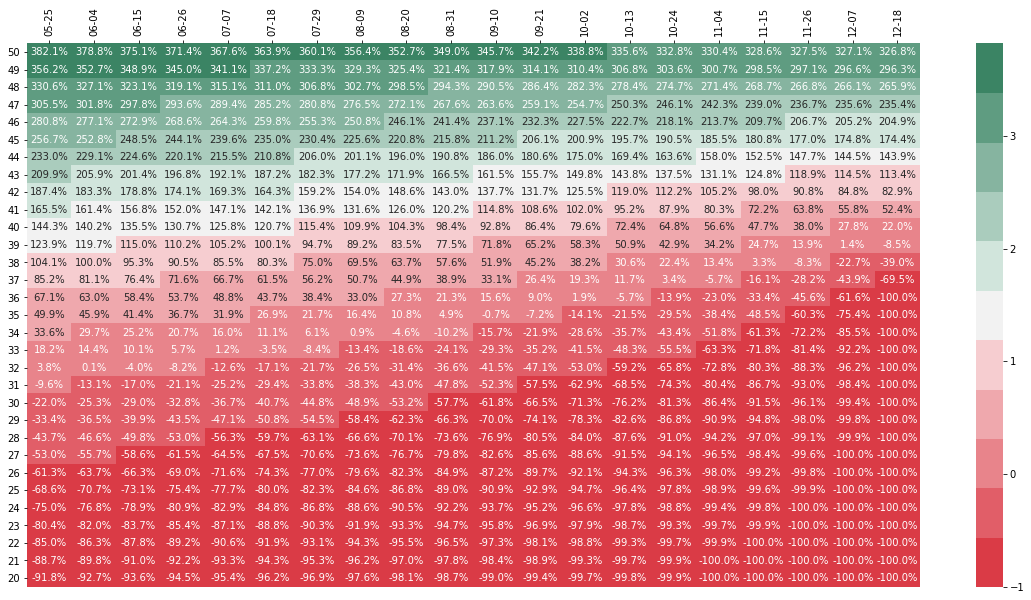

In [57]:
return_pcts = (df_option_prices / contract_price) - 1
plt.figure(figsize=(20,10))
ax = sb.heatmap(
    return_pcts,
    annot=True,
    fmt = '.1%',
    cmap = sb.diverging_palette(10, 150, n=11))
ax.xaxis.set_ticks_position('top')
ax.set_xticklabels(df_option_prices.columns.strftime('%m-%d'), rotation=90)
ax.set_yticklabels(df_option_prices.index, rotation=0)
plt.show()